In [ ]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet201
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


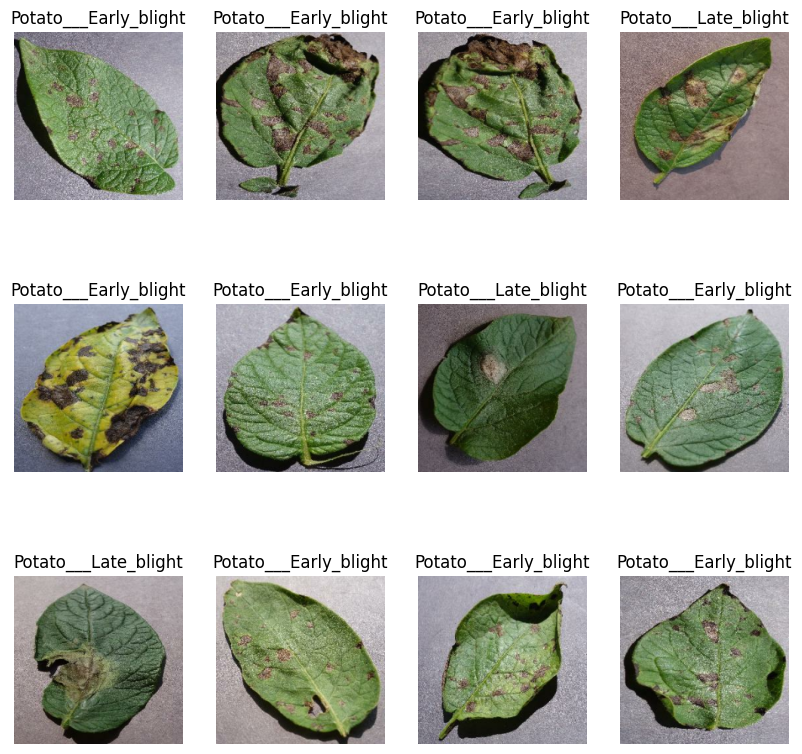

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.70
len(dataset)*train_size

47.599999999999994

In [ ]:
train_dataset = dataset.take(48)
len(train_dataset)

48

In [ ]:
test_dataset = dataset.skip(48)
len(test_dataset)

20

In [ ]:
val_size=0.15
len(dataset)*val_size

10.2

In [ ]:
val_dataset = test_dataset.skip(10)
len(val_dataset)

10

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.70, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_dataset)

47

In [ ]:
len(test_dataset)

11

In [ ]:
len(val_dataset)

10

In [ ]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),

])


In [ ]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def build_vgg19():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    model = Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

# Function to build custom InceptionV3 model with regularization and data augmentation
def build_inceptionV3():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()

    # Add the InceptionV3 base model
    model.add(base_model)

    # Add more layers with regularization
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))

    # Output Dense layer with 3 units (assuming it's a classification task) and softmax activation
    model.add(layers.Dense(3, activation='softmax'))

    return model



In [ ]:
vgg19_model = build_vgg19()
vgg19_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.(learning_rate=0.0001),
    metrics=['accuracy']
)

# ... (your previous code)

# Build and compile the regularized custom InceptionV3 model with data augmentation
inceptionV3_model = build_inceptionV3()
inceptionV3_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)



87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
lr_schedule = ReduceLROnPlateau(factor=0.1, patience=3)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
history_vgg19 = vgg19_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/30
47/47 [==============================] - 206s 822ms/step - loss: 7.2145 - accuracy: 0.3419 - val_loss: 6.7415 - val_accuracy: 0.5188 - lr: 1.0000e-04
Epoch 2/30
47/47 [==============================] - 40s 707ms/step - loss: 6.5625 - accuracy: 0.4601 - val_loss: 6.3716 - val_accuracy: 0.4595 - lr: 1.0000e-04
Epoch 3/30
47/47 [==============================] - 37s 660ms/step - loss: 6.1919 - accuracy: 0.4781 - val_loss: 5.9984 - val_accuracy: 0.4595 - lr: 1.0000e-04
Epoch 4/30
47/47 [==============================] - 42s 741ms/step - loss: 5.8316 - accuracy: 0.4662 - val_loss: 5.6209 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 5/30
47/47 [==============================] - 38s 679ms/step - loss: 5.4799 - accuracy: 0.4480 - val_loss: 5.2555 - val_accuracy: 0.4938 - lr: 1.0000e-04
Epoch 6/30
47/47 [==============================] - 38s 683ms/step - loss: 5.1340 - accuracy: 0.4847 - val_loss: 4.9099 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 7/30
47/47 [=====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


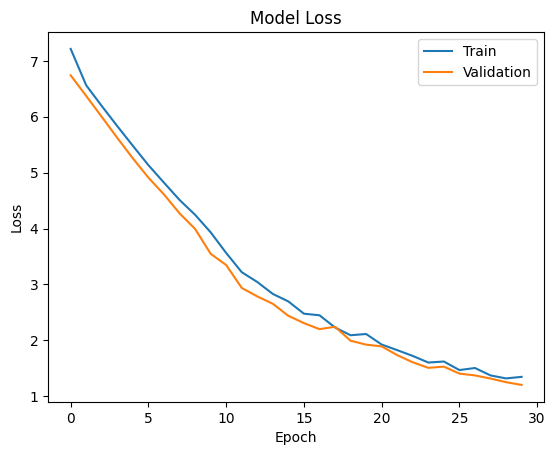

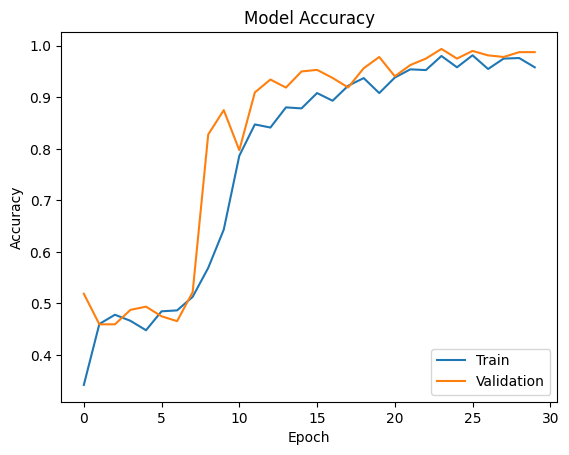

In [ ]:
print(history_vgg19.history.keys())
# Output: ['loss', 'accuracy', 'val_loss', 'val_accuracy']

# Plot training and validation loss over epochs
plt.plot(history_vgg19.history['loss'])
plt.plot(history_vgg19.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history_vgg19.history['accuracy'])
plt.plot(history_vgg19.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score

# Assuming you have already trained your VGG19 model and obtained predictions on the validation set
y_val_true = []
y_val_pred_probs = []

for x_val_batch, y_val_batch in val_dataset:
    y_val_true.extend(y_val_batch.numpy())
    y_val_pred_probs.extend(vgg19_model.predict(x_val_batch))

y_val_true = np.array(y_val_true)
y_val_pred = np.argmax(np.array(y_val_pred_probs), axis=1)  # Convert probabilities to class labels

# Calculate precision and recall
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')

# Print the classification report
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

1/1 [==============================] - 0s 26ms/step
Weighted Precision: 0.9883
Weighted Recall: 0.9875
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       131
 Potato___Late_blight       0.99      0.98      0.99       168
     Potato___healthy       0.87      0.95      0.91        21

             accuracy                           0.99       320
            macro avg       0.95      0.98      0.97       320
         weighted avg       0.99      0.99      0.99       320



In [ ]:
vgg19_model_1=vgg19_model.save('/content/drive/MyDrive/model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_accuracy_vgg19 = history_vgg19.history['accuracy']
val_accuracy_vgg19 = history_vgg19.history['val_accuracy']
# Print the final accuracy values after the last epoch
print("VGG19 Model - Final Training Accuracy:", train_accuracy_vgg19[-2])
print("VGG19 Model - Final Validation Accuracy:", val_accuracy_vgg19[-2])

VGG19 Model - Final Training Accuracy: 0.9760638475418091
VGG19 Model - Final Validation Accuracy: 0.987500011920929


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])


In [ ]:
def build_inceptionV3():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()

    # Add the InceptionV3 base model
    model.add(base_model)
    model.add(resize_and_rescale)

    # Add more layers with regularization
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))

    # Output Dense layer with 3 units (assuming it's a classification task) and softmax activation
    model.add(layers.Dense(3, activation='softmax'))

    return model

In [ ]:
history_inceptionV3 = inceptionV3_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/30
47/47 [==============================] - 29s 481ms/step - loss: 6.0502 - accuracy: 0.7534 - val_loss: 6.0037 - val_accuracy: 0.7312 - lr: 1.0000e-04
Epoch 2/30
47/47 [==============================] - 25s 406ms/step - loss: 5.9719 - accuracy: 0.7405 - val_loss: 5.8760 - val_accuracy: 0.7563 - lr: 1.0000e-04
Epoch 3/30
47/47 [==============================] - 29s 487ms/step - loss: 5.8671 - accuracy: 0.7547 - val_loss: 5.7829 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/30
47/47 [==============================] - 30s 513ms/step - loss: 5.8005 - accuracy: 0.7480 - val_loss: 5.6454 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 5/30
47/47 [==============================] - 25s 404ms/step - loss: 5.7055 - accuracy: 0.7608 - val_loss: 5.6380 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/30
47/47 [==============================] - 27s 411ms/step - loss: 5.6353 - accuracy: 0.7554 - val_loss: 5.5583 - val_accuracy: 0.7534 - lr: 1.0000e-04
Epoch 7/30
47/47 [======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


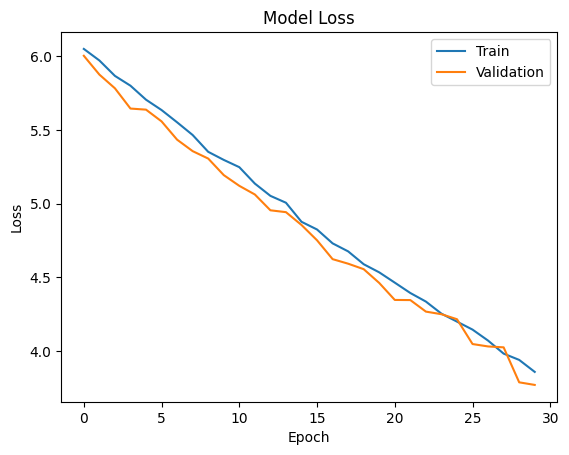

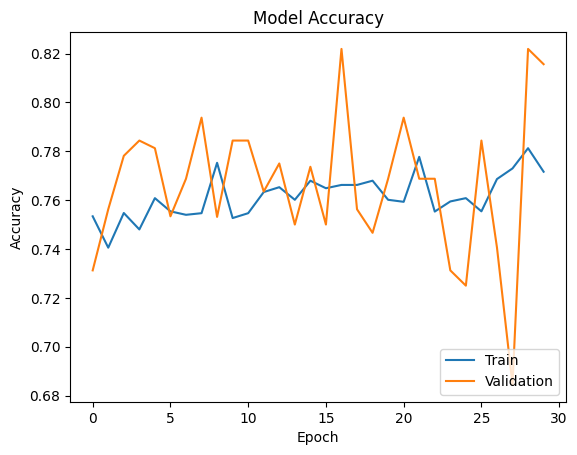

In [ ]:
print(history_inceptionV3.history.keys())
# Output: ['loss', 'accuracy', 'val_loss', 'val_accuracy']

# Plot training and validation loss over epochs
plt.plot(history_inceptionV3.history['loss'])
plt.plot(history_inceptionV3.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history_inceptionV3.history['accuracy'])
plt.plot(history_inceptionV3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score

# Assuming you have already trained your VGG19 model and obtained predictions on the validation set
y_val_true = []
y_val_pred_probs = []

for x_val_batch, y_val_batch in val_dataset:
    y_val_true.extend(y_val_batch.numpy())
    y_val_pred_probs.extend(inceptionV3_model.predict(x_val_batch))

y_val_true = np.array(y_val_true)
y_val_pred = np.argmax(np.array(y_val_pred_probs), axis=1)  # Convert probabilities to class labels

# Calculate precision and recall
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')

# Print the classification report
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

1/1 [==============================] - 0s 33ms/step
Weighted Precision: 0.7149
Weighted Recall: 0.7719
                       precision    recall  f1-score   support

Potato___Early_blight       0.75      0.93      0.83       149
 Potato___Late_blight       0.80      0.75      0.77       146
     Potato___healthy       0.00      0.00      0.00        25

             accuracy                           0.77       320
            macro avg       0.52      0.56      0.53       320
         weighted avg       0.71      0.77      0.74       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
inceptionV3_model=custom_inception_model_regularized.save('/content/drive/MyDrive/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# train_accuracy_vgg19 =history_custom_inception_regularized.history['accuracy']
# val_accuracy_vgg19 = history_custom_inception_regularized.history['val_accuracy']
# # Print the final accuracy values after the last epoch
# print("InceptionV3 Model - Final Training Accuracy:", train_accuracy_vgg19[-1])
# print("InceptionV3 - Final Validation Accuracy:", val_accuracy_vgg19[-1])

InceptionV3 Model - Final Training Accuracy: 0.7506648898124695
InceptionV3 - Final Validation Accuracy: 0.7593749761581421


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [ ]:
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# build the entire model
x = resnet_50.output

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)


In [ ]:
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)

In [ ]:
model_history = trainModel(model = model, epochs = 20, optimizer = "Adam")

Epoch 1/20
47/47 [==============================] - 37s 504ms/step - loss: 1.0253 - accuracy: 0.6372 - val_loss: 0.2953 - val_accuracy: 0.9031
Epoch 2/20
47/47 [==============================] - 26s 401ms/step - loss: 0.3358 - accuracy: 0.8736 - val_loss: 0.2036 - val_accuracy: 0.9493
Epoch 3/20
47/47 [==============================] - 26s 425ms/step - loss: 0.2417 - accuracy: 0.9128 - val_loss: 0.1389 - val_accuracy: 0.9656
Epoch 4/20
47/47 [==============================] - 27s 453ms/step - loss: 0.1845 - accuracy: 0.9351 - val_loss: 0.0992 - val_accuracy: 0.9595
Epoch 5/20
47/47 [==============================] - 28s 471ms/step - loss: 0.1490 - accuracy: 0.9527 - val_loss: 0.0979 - val_accuracy: 0.9594
Epoch 6/20
47/47 [==============================] - 29s 479ms/step - loss: 0.1149 - accuracy: 0.9648 - val_loss: 0.1990 - val_accuracy: 0.9500
Epoch 7/20
47/47 [==============================] - 29s 473ms/step - loss: 0.1445 - accuracy: 0.9534 - val_loss: 0.0668 - val_accuracy: 0.9719

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


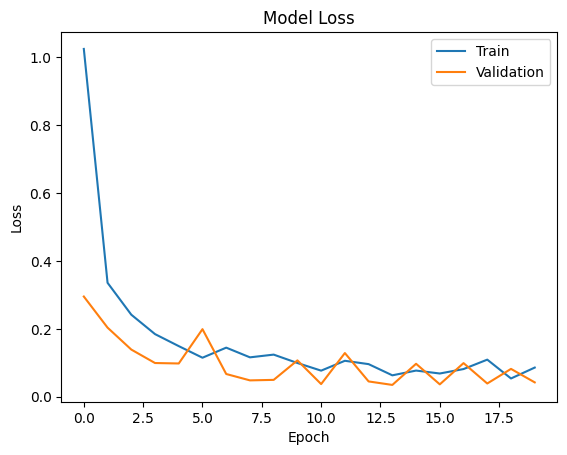

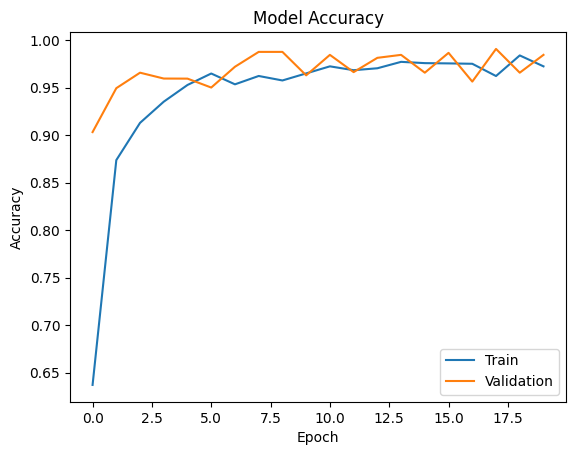

In [ ]:
print(model_history.history.keys())
# Output: ['loss', 'accuracy', 'val_loss', 'val_accuracy']

# Plot training and validation loss over epochs
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score

# Assuming you have already trained your VGG19 model and obtained predictions on the validation set
y_val_true = []
y_val_pred_probs = []

for x_val_batch, y_val_batch in val_dataset:
    y_val_true.extend(y_val_batch.numpy())
    y_val_pred_probs.extend(model.predict(x_val_batch))

y_val_true = np.array(y_val_true)
y_val_pred = np.argmax(np.array(y_val_pred_probs), axis=1)  # Convert probabilities to class labels

# Calculate precision and recall
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')

# Print the classification report
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

1/1 [==============================] - 0s 30ms/step
Weighted Precision: 0.9844
Weighted Recall: 0.9844
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.99      1.00       144
 Potato___Late_blight       0.98      0.99      0.98       153
     Potato___healthy       0.91      0.91      0.91        23

             accuracy                           0.98       320
            macro avg       0.96      0.96      0.96       320
         weighted avg       0.98      0.98      0.98       320



In [ ]:
resnet50_model=model.save('/content/drive/MyDrive/model_3.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os

# Specify the path to the dataset directory
dataset_dir_path = '/content/drive/MyDrive/Potato Dataset'  # Replace with the actual path to your dataset directory

# List the names of the classes (subdirectories)
classes = os.listdir(dataset_dir_path)
print("Classes in the dataset:", class_names)

Classes in the dataset: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


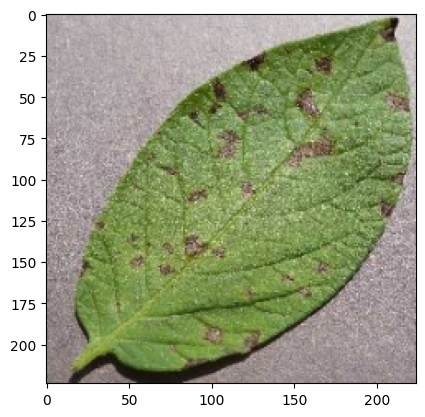

In [ ]:
from keras.models import load_model
import numpy as np
for images_batch, labels_batch in train_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    vgg19model= load_model ('/content/drive/MyDrive/model1.h5')
    batch_prediction = vgg19model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = vgg19model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


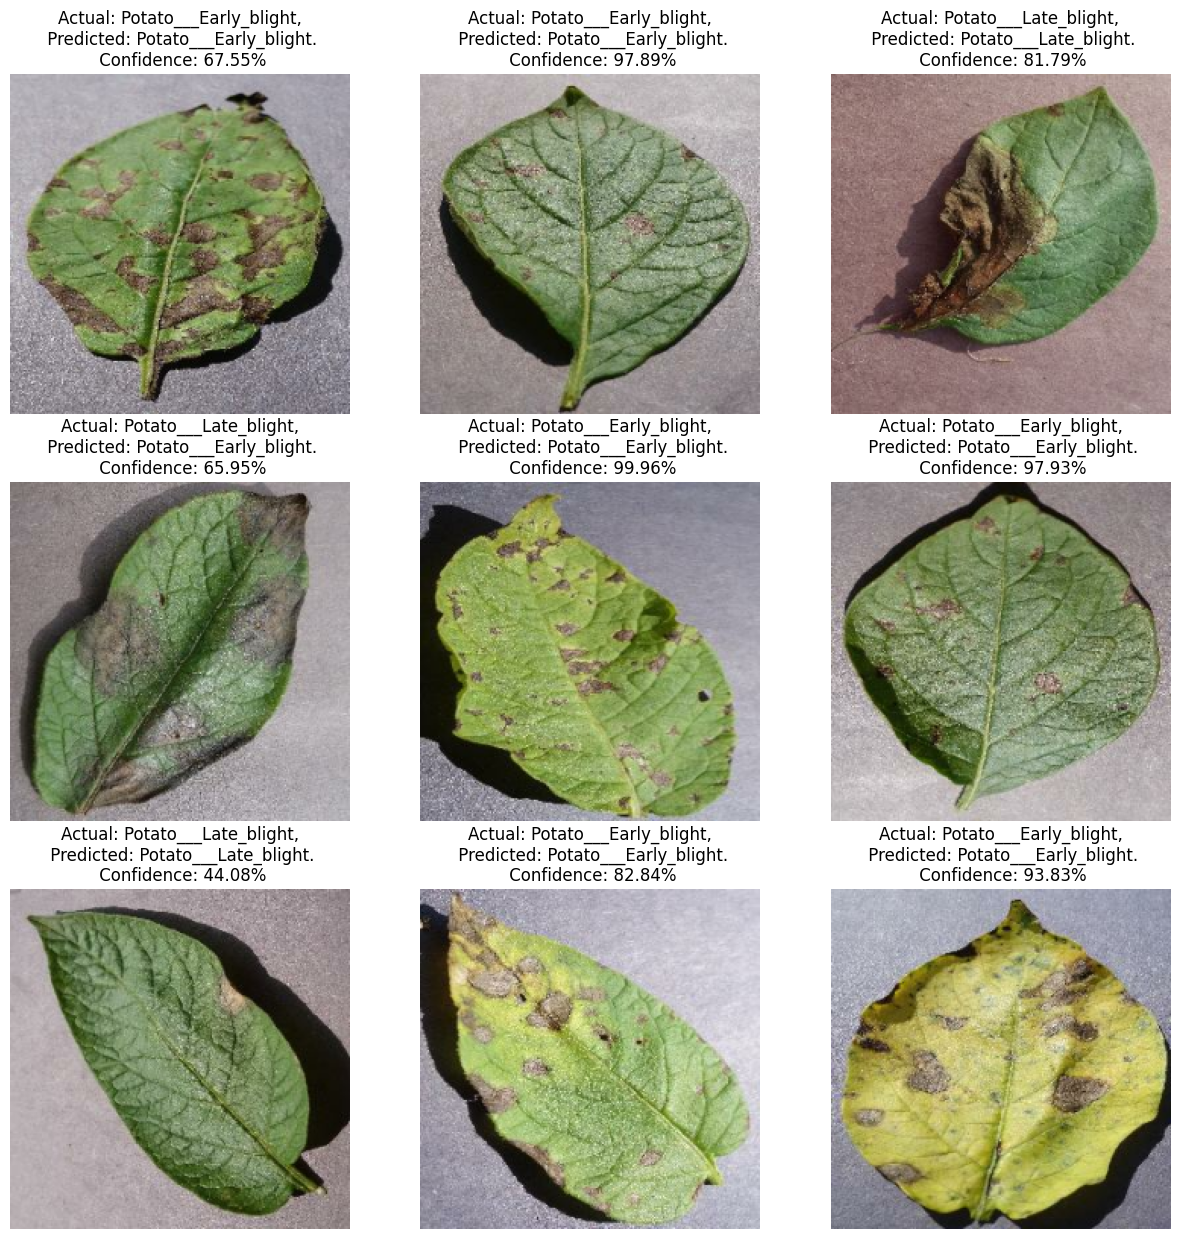

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 95ms/step


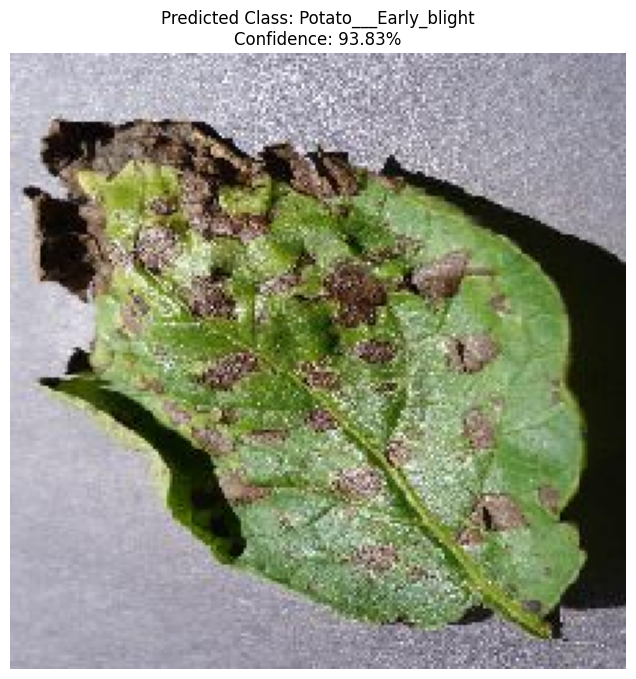

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_single_image_prediction(model, image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]

    # Make prediction
    predicted_class, confidence = predict(model, img_array.numpy())

    # Convert to NumPy array for display
    img_array_display = img_array[0].numpy() * 255
    img_array_display = img_array_display.astype("uint8")

    # Plot the image and prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img_array_display)
    plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")
    plt.show()

# Usage
image_path = "/content/drive/MyDrive/Potato Dataset/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG"  # Replace with the path to your image
plot_single_image_prediction(model, image_path)


In [ ]:


from tensorflow.keras.models import load_model

# Replace '/path/to/your/saved_model.h5' with the actual path to your saved model file
model_path = '/content/drive/MyDrive/model_1.h5'  # Example path, replace it with your actual path
loaded_model = load_model(model_path)

# Now you can use the loaded_model for predictions, evaluation, etc.


1/1 [==============================] - 3s 3s/step


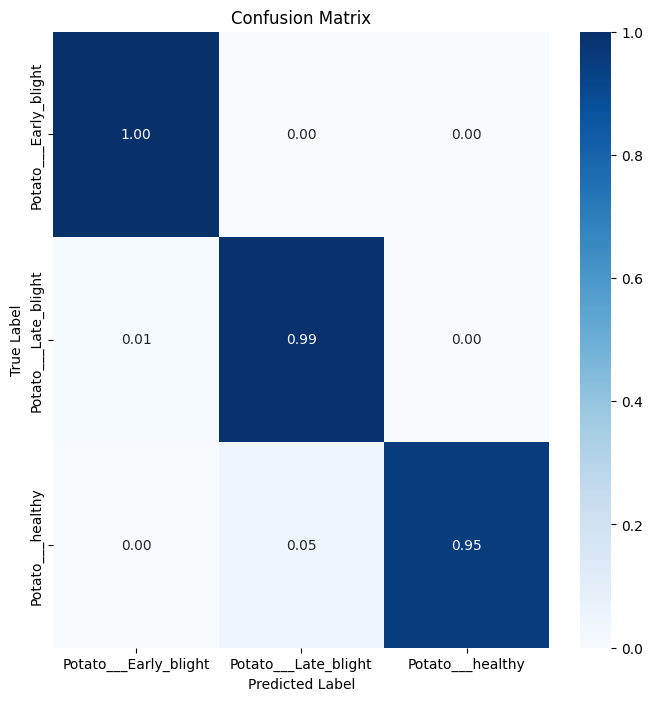

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to get predictions on a dataset using a given model
def get_predictions(model, dataset):
    predictions = []
    true_labels = []

    for x_batch, y_batch in dataset:
        predictions.extend(model.predict(x_batch))
        true_labels.extend(y_batch.numpy())

    return np.argmax(np.array(predictions), axis=1), true_labels

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Get predictions for each model on the validation set
y_val_pred_vgg19, y_val_true_vgg19 = get_predictions(loaded_model, val_dataset)
# y_val_pred_inceptionV3, y_val_true_inceptionV3 = get_predictions(inceptionV3_model, val_dataset)
# y_val_pred_resnet50, y_val_true_resnet50 = get_predictions(model, val_dataset)

# Plot confusion matrix for each model
plot_confusion_matrix(y_val_true_vgg19, y_val_pred_vgg19, class_names)
# plot_confusion_matrix(y_val_true_inceptionV3, y_val_pred_inceptionV3, class_names)
# plot_confusion_matrix(y_val_true_resnet50, y_val_pred_resnet50, class_names)


In [ ]:



# Replace '/path/to/your/saved_model.h5' with the actual path to your saved model file
model_path = '/content/drive/MyDrive/model1.h5'  # Example path, replace it with your actual path
loaded_model1 = load_model(model_path)

# Now you can use the loaded_model for predictions, evaluation, etc.


1/1 [==============================] - 0s 33ms/step


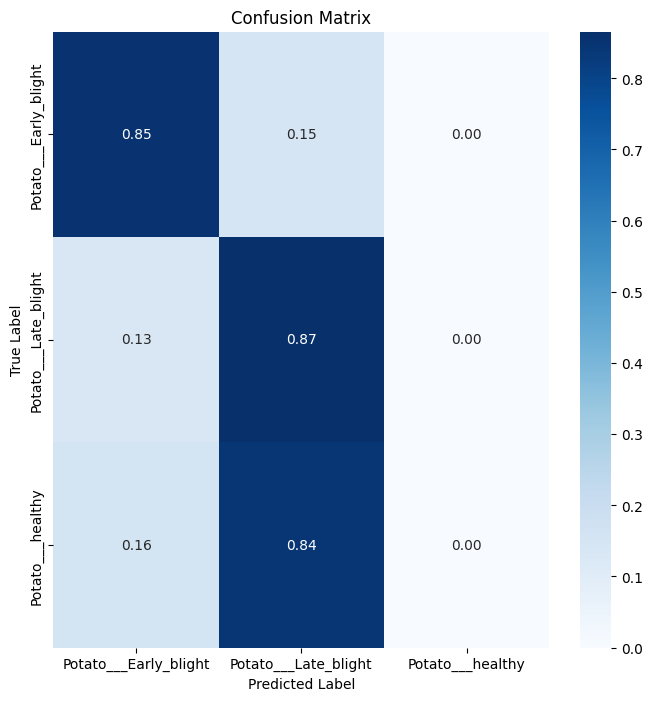

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to get predictions on a dataset using a given model
def get_predictions(model, dataset):
    predictions = []
    true_labels = []

    for x_batch, y_batch in dataset:
        predictions.extend(model.predict(x_batch))
        true_labels.extend(y_batch.numpy())

    return np.argmax(np.array(predictions), axis=1), true_labels

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Get predictions for each model on the validation set
# y_val_pred_vgg19, y_val_true_vgg19 = get_predictions(loaded_model1, val_dataset)
y_val_pred_inceptionV3, y_val_true_inceptionV3 = get_predictions(loaded_model1, val_dataset)
# y_val_pred_resnet50, y_val_true_resnet50 = get_predictions(model, val_dataset)

# Plot confusion matrix for each model
# plot_confusion_matrix(y_val_true_vgg19, y_val_pred_vgg19, class_names)
plot_confusion_matrix(y_val_true_inceptionV3, y_val_pred_inceptionV3, class_names)
# plot_confusion_matrix(y_val_true_resnet50, y_val_pred_resnet50, class_names)


In [ ]:



# Replace '/path/to/your/saved_model.h5' with the actual path to your saved model file
model_path = '/content/drive/MyDrive/model_3.h5'  # Example path, replace it with your actual path
loaded_model2 = load_model(model_path)

# Now you can use the loaded_model for predictions, evaluation, etc.


1/1 [==============================] - 2s 2s/step


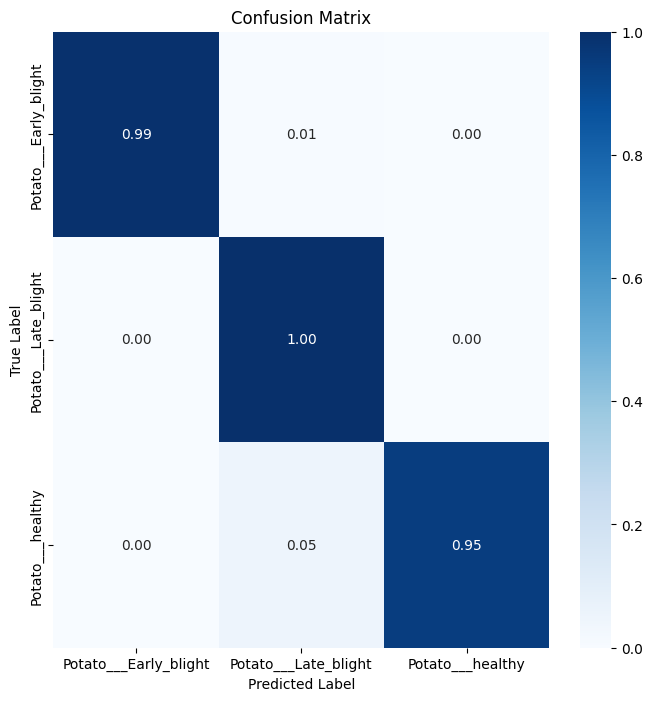

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to get predictions on a dataset using a given model
def get_predictions(model, dataset):
    predictions = []
    true_labels = []

    for x_batch, y_batch in dataset:
        predictions.extend(model.predict(x_batch))
        true_labels.extend(y_batch.numpy())

    return np.argmax(np.array(predictions), axis=1), true_labels

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Get predictions for each model on the validation set
# y_val_pred_vgg19, y_val_true_vgg19 = get_predictions(loaded_model1, val_dataset)
# y_val_pred_inceptionV3, y_val_true_inceptionV3 = get_predictions(loaded_model1, val_dataset)
y_val_pred_resnet50, y_val_true_resnet50 = get_predictions(loaded_model2, val_dataset)

# Plot confusion matrix for each model
# plot_confusion_matrix(y_val_true_vgg19, y_val_pred_vgg19, class_names)
# plot_confusion_matrix(y_val_true_inceptionV3, y_val_pred_inceptionV3, class_names)
plot_confusion_matrix(y_val_true_resnet50, y_val_pred_resnet50, class_names)
